In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

## Importing modules

In [2]:
import warnings
warnings.simplefilter("ignore")
import numpy as np
import keras
%pylab inline

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


## Getting data

In [3]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [4]:
from os import listdir
from PIL import Image

#My pictures (were made in paint)
path_to_digits = "./myDigits/"
dfiles = listdir(path_to_digits)

imgs = [np.array(Image.open(path_to_digits+img).convert('L')).reshape(784) - 255 for img in dfiles]
imgs_y = [i // 10 for i in range(100)]

## Draw some digits from dataset

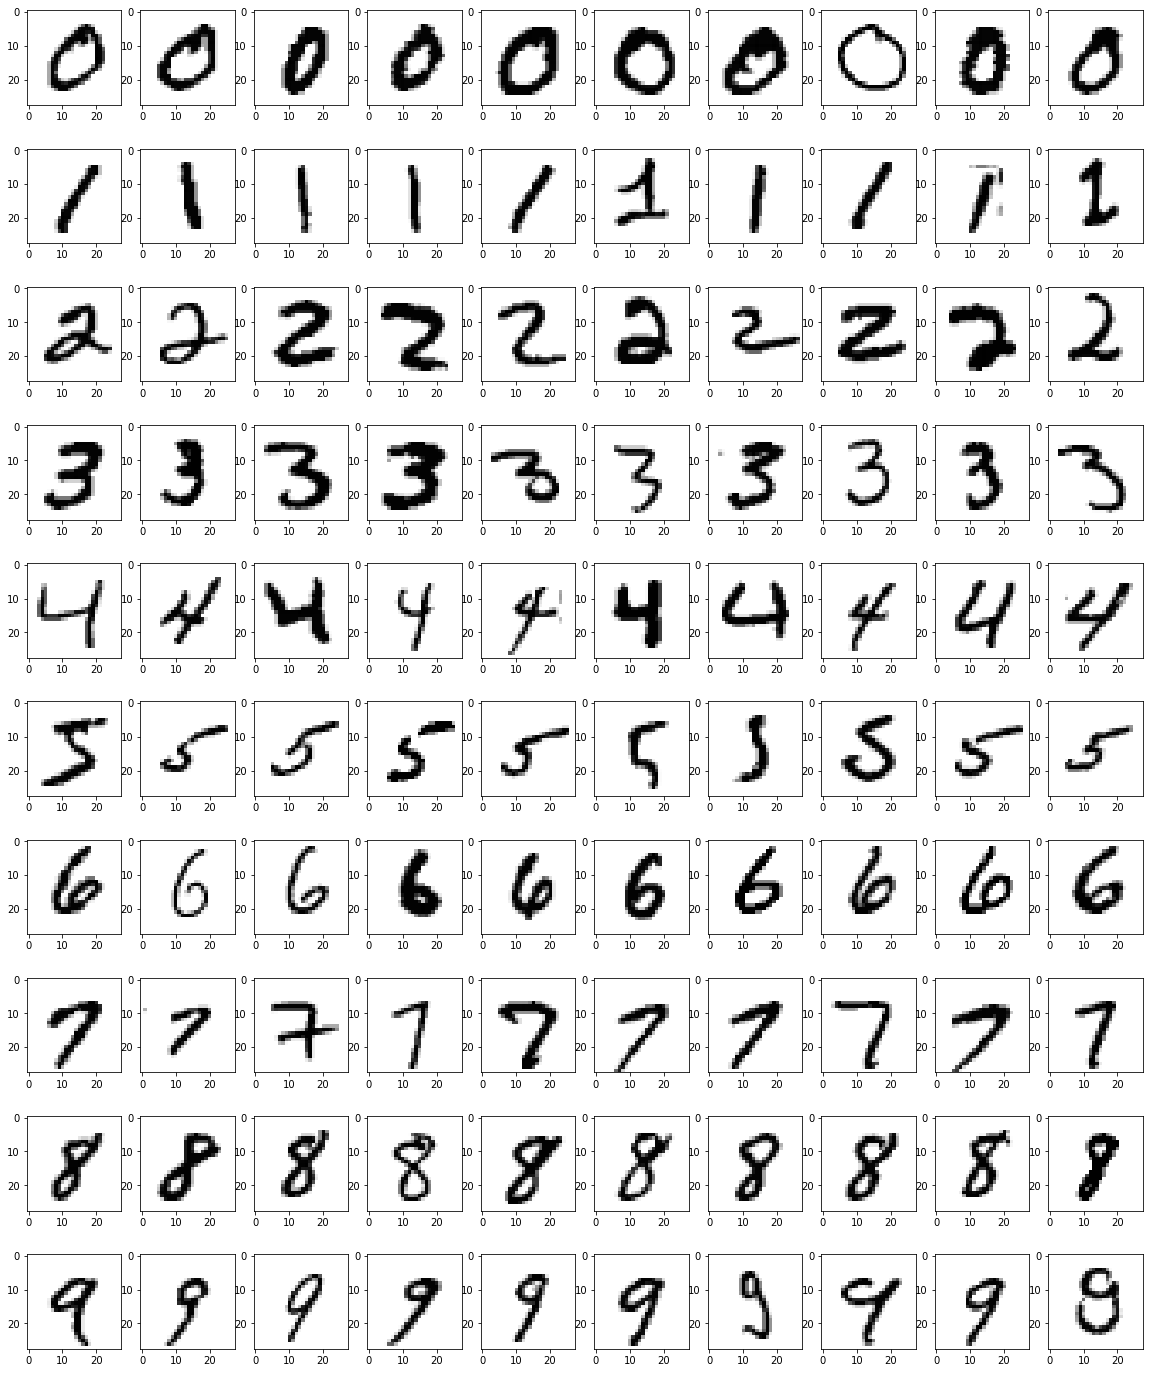

In [5]:
def draw_pic(data):
    plt.imshow([[1-y for y in x] for x in data], cmap="gray")
    pass

plt.figure(figsize=(20, 25))
for j in range(10):
    needed_nums = np.where(y_train == j)
    for i in range(10):
        plt.subplot(10, 10, 10*j+i+1)
        draw_pic(x_train[needed_nums[0][i]])

## Splitting data

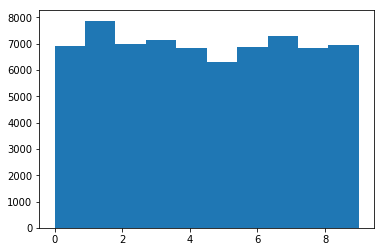

In [6]:
# Take a look on class distribution 
plt.hist(np.concatenate((y_train, y_test), axis=0))
pass

In [7]:
from keras.utils import np_utils

num_train = 60000
num_test = 10000

height, width, depth = 28, 28, 1
num_classes = 10

x_train = x_train.reshape(num_train, height * width)
x_test = x_test.reshape(num_test, height * width)

x_train = x_train.astype('float32') 
x_test = x_test.astype('float32')

x_train /= 255 # Normalise data to [0, 1] range
x_test /= 255 # Normalise data to [0, 1] range
imgs = np.array(imgs) / 255

In [8]:
from sklearn.model_selection import train_test_split

xa, xb, ya, yb = train_test_split(x_train, y_train, test_size=0.5, random_state=13)

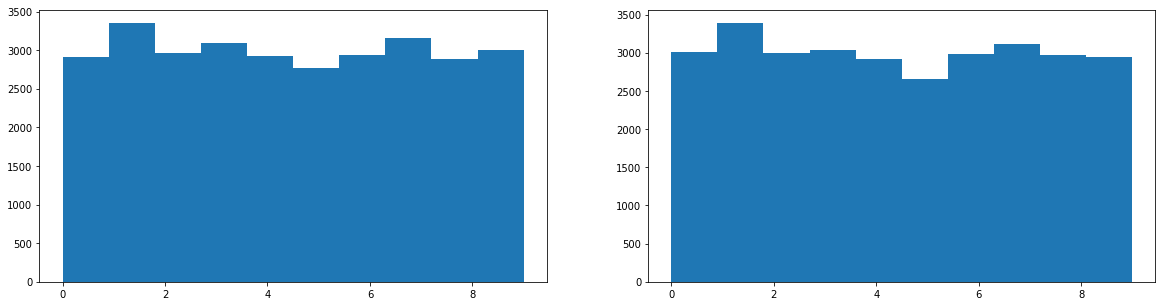

In [9]:
# Class distribution after splitting
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.hist(ya)
plt.subplot(1, 2, 2)
plt.hist(yb)
pass

## One-hot encode the labels

In [10]:
ya = np_utils.to_categorical(ya, 10) 
yb = np_utils.to_categorical(yb, 10)
y_test = np_utils.to_categorical(y_test, 10)
imgs_y = np_utils.to_categorical(imgs_y, 10)

## A/B test

I am going to test how **CNN** can improve accuracy.

First of all, I need a baseline. I will use **simple MLP**, which is presented below.

### Model A

In [11]:
from keras.layers import Dense, Dropout, Activation, Conv1D, Input
from keras.models import Model

inp = Input(shape=(784,))
hidden_1 = Dense(128, activation='relu')(inp)
hidden_2 = Dense(128, activation='relu')(hidden_1)
out = Dense(10, activation='softmax')(hidden_2)

model = Model(input=inp, output=out)
model.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [12]:
model.fit(xa, ya,
          batch_size=128, nb_epoch=5,
          verbose=1, validation_split=0.1)
pass

Train on 27000 samples, validate on 3000 samples
Epoch 1/5
27000/27000 [==============================] - 3s 93us/step - loss: 0.4824 - acc: 0.8658 - val_loss: 0.2332 - val_acc: 0.9300
Epoch 2/5
27000/27000 [==============================] - 1s 41us/step - loss: 0.1931 - acc: 0.9439 - val_loss: 0.1765 - val_acc: 0.9493
Epoch 3/5
27000/27000 [==============================] - 1s 43us/step - loss: 0.1394 - acc: 0.9584 - val_loss: 0.1499 - val_acc: 0.9587
Epoch 4/5
27000/27000 [==============================] - 1s 42us/step - loss: 0.1061 - acc: 0.9686 - val_loss: 0.1286 - val_acc: 0.9637
Epoch 5/5
27000/27000 [==============================] - 1s 41us/step - loss: 0.0810 - acc: 0.9753 - val_loss: 0.1224 - val_acc: 0.9620


In [13]:
print("Accuracy on MNIST:", model.evaluate(x_test, y_test)[1])

10000/10000 [==============================] - 0s 38us/step
Accuracy on MNIST: 0.9645


This metric is not to scale, as it was modeled out of data similar to train dataset.

In [14]:
print("Accuracy on self-made images:", model.evaluate(imgs, imgs_y)[1])

100/100 [==============================] - 0s 90us/step
Accuracy on self-made images: 0.11


Woah! This is bad... Seems like model "A" can't find dependecies in self-made images

### Model B

In [15]:
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
input_shape = (28, 28, 1)

xa, xb, ya, yb = train_test_split(x_train, y_train, test_size=0.5, random_state=13)
yb = np_utils.to_categorical(yb, 10)

In [17]:
from keras.layers import Conv2D, MaxPooling2D, Flatten
from keras.models import Sequential

model = Sequential() 
model.add(Conv2D(32, (5,5), activation='relu', input_shape=(28,28,1)))
model.add(Conv2D(32, (5,5), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(32, (5,5), activation='relu'))
model.add(Flatten())
model.add(Dense(units=256, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=10))
model.add(Activation('softmax'))

# Initialize and compile:
keras.initializers.TruncatedNormal(mean=0.0, stddev=0.05, seed=None)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
model.fit(xb, yb,
          batch_size=128, nb_epoch=5,
          verbose=1, validation_split=0.1)
pass

Train on 27000 samples, validate on 3000 samples
Epoch 1/5
27000/27000 [==============================] - 142s 5ms/step - loss: 0.2901 - acc: 0.9113 - val_loss: 0.0882 - val_acc: 0.9743
Epoch 2/5
27000/27000 [==============================] - 159s 6ms/step - loss: 0.0675 - acc: 0.9792 - val_loss: 0.0786 - val_acc: 0.9743
Epoch 3/5
27000/27000 [==============================] - 158s 6ms/step - loss: 0.0477 - acc: 0.9846 - val_loss: 0.0568 - val_acc: 0.9837
Epoch 4/5
27000/27000 [==============================] - 193s 7ms/step - loss: 0.0319 - acc: 0.9899 - val_loss: 0.0502 - val_acc: 0.9857
Epoch 5/5
27000/27000 [==============================] - 212s 8ms/step - loss: 0.0250 - acc: 0.9918 - val_loss: 0.0466 - val_acc: 0.9890


In [19]:
print("Accuracy on MNIST:", model.evaluate(x_test, y_test)[1])

10000/10000 [==============================] - 26s 3ms/step
Accuracy on MNIST: 0.9855


In [20]:
print("Accuracy on self-made images:", model.evaluate(imgs.reshape(100, 28, 28, 1), imgs_y)[1])

100/100 [==============================] - 0s 3ms/step
Accuracy on self-made images: 0.22


So that's better!

## Conclusion

Simple CNN gives better accuracy than simple MLP.

That is what I tried to confirm by my A/B test.